In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import time
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
import logging
import sys
import os


def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [3]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [4]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [5]:
example_document = index.document(index.document_base())
print(example_document)

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [6]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [7]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [8]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [9]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [10]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [40 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[10 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [11]:
with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')
start_time = time.time()
num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 26.462878465652466 seconds.


In [12]:
def run_retrieval(model_name, score_fn, **args):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}
    
    for qid in tokenized_queries.keys(): #for each query
#     for qid in ['135']: #test

        score = {}
            #hack for BM25 (iterate duplicate terms in query once)
        try:
            if score_fn==bm25:
                tokenized_queries[qid] = list(set(tokenized_queries[qid]))
        except:
            pass
        
        for query_term_id in tokenized_queries[qid]: #for each word_id in query

            for (int_document_id,document_term_freq) in zip(inverted_index[query_term_id].keys(),inverted_index[query_term_id].values()):
                    #for each document where the word appears, calculate scoring function increment its score
                new_score = score_fn(int_document_id, query_term_id, document_term_freq, **args)
                
                if int_document_id not in score.keys():
                    #print('initiallizing and incrementing score')
                    score[int_document_id] = new_score
                else:
                    #print('incrementing score')
                    score[int_document_id] += new_score

        #turn dict to list of tuples and continue        
        # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
        data[qid] = [(score, index.ext_document_id(doc_id)) for (score, doc_id) in zip(score.values(), score.keys())]
        
#     write out
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

In [13]:
def test_fn(int_document_id, query_term_id, document_term_freq):
    #test function returning the occurencies themselves as a score
    #return inverted_index[query_term_id][int_document_id]
    return 1.

run_retrieval('retrievals/test',test_fn)

### TF-IDF

In [14]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """   
    
    ## Amount of time a term appears in a document  
    df = document_term_freq
    ## Total terms in a document
    dl = document_lengths[int_document_id]
    ## Amount of documents containing a term
    n = len(inverted_index[query_term_id])
    
    tf = np.log2(1 + (df/dl))
    idf = np.log2((n/df))
    
    score = tf * idf

    return score

In [15]:
start_time = time.time()

run_retrieval('retrievals/tf-idf',tfidf)

print ('elapsed time:',time.time()-start_time)

elapsed time: 0.00022983551025390625


In [16]:
# trec_eval command for evalutaion of tf-idf 

!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.1800
recall_1000           	all	0.4737
ndcg_cut_10           	all	0.1699
map_cut_1000          	all	0.1102


### BM25

** TODO1: optimize-cache results - doesnt run - too slow-------->DONE!!! **

**  TODO2: sum only over unique query terms -----------------> DONE!!! **


In [17]:
for q_id,q in zip(tokenized_queries.keys() ,tokenized_queries.values()):
    if len(q) != len(set(q)):
        print('query %s has duplicate words!'%q_id)

query 200 has duplicate words!
query 127 has duplicate words!
query 102 has duplicate words!


In [18]:
def bm25(int_document_id, query_term_id, document_term_freq ,k1=1.2 , b=0.75,length_avg = round(np.mean(np.array(list(document_lengths.values())))) ):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    
    Hyperparameters: k1=1.2 and b=0.75
    
    """
    
    ## Amount of time a term appears in a document  
    df = document_term_freq
     
    
    ## tf, idf
    tf = np.log2(1 + (df/document_lengths[int_document_id]))
    idf = np.log2((len(inverted_index[query_term_id])/df))
    
    ## Total terms in a document : document_lengths[int_document_id]    
    ## Amount of documents containing a term : len(inverted_index[query_term_id])
    ## document length : document_lengths[int_document_id]
    
    return ((k1+1)*tf*idf)/(k1*((1-b)+b*(document_lengths[int_document_id] /length_avg))+tf)

In [19]:
start_time=time.time() 

run_retrieval('retrievals/bm25',bm25)

print('BM25 scoring took', time.time() - start_time, 'seconds.')

BM25 scoring took 0.00011396408081054688 seconds.


In [20]:
# trec_eval command for evalutaion of bm25

!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/bm25.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.1133
recall_1000           	all	0.3840
ndcg_cut_10           	all	0.1069
map_cut_1000          	all	0.0769


### Jelinek-Mercer

In [21]:
#precompute the 2nd term of jelinek mercer smoothening to speed-up computations
P_mle_col = dict()
for query_term_id in query_term_ids:
    P_mle_col[query_term_id] = index.get_term_frequencies()[query_term_id] / index.total_terms()

In [22]:
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, lambd = 0.75):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param lambd: lambda value of linear interpolation (default = 0.75)
    """
    P_mle_doc = document_term_freq / document_lengths[int_document_id]
    
    return ( (lambd * P_mle_doc) + ((1-lambd)*P_mle_col[query_term_id]) )

In [23]:
#final run
start_time = time.time()
test_dict = run_retrieval('retrievals/jelinek_mercer',jelinek_mercer)
print ('elapsed time:',time.time()-start_time)

elapsed time: 0.00011920928955078125


In [24]:
# trec_eval command for evalutaion of jelinek_mercer

!trec_eval -m all_trec -q ./ap_88_89/qrel_validation retrievals/jelinek_mercer.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	103	0.2000
recall_1000           	103	0.6000
ndcg_cut_10           	103	0.2466
map_cut_1000          	103	0.1724
P_5                   	111	0.8000
recall_1000           	111	0.7500
ndcg_cut_10           	111	0.6300
map_cut_1000          	111	0.1695
P_5                   	114	0.2000
recall_1000           	114	0.6585
ndcg_cut_10           	114	0.2817
map_cut_1000          	114	0.1187
P_5                   	120	0.2000
recall_1000           	120	0.1250
ndcg_cut_10           	120	0.1100
map_cut_1000          	120	0.0135
P_5                   	123	0.0000
recall_1000           	123	0.0286
ndcg_cut_10           	123	0.0000
map_cut_1000          	123	0.0002
P_5                   	135	0.2000
recall_1000           	135	0.6267
ndcg_cut_10           	135	0.2431
map_cut_1000          	135	0.1585
P_5                   	143	0.0000
recall_1000           	143	0.2583
ndcg_cut_10           	143	0.0000
map_cut_1000          	143	0.0179
P_5                   	144	0.2000
recall_1000   

In [25]:
for param_value in np.arange(0.01,0.091,0.01):
    start_time = time.time()
    filename = 'retrievals/jelinek_mercer_lambda='+str(param_value)
    
    run_retrieval(filename,jelinek_mercer, lambd = param_value)
    
    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

finished retrievals/jelinek_mercer_lambda=0.01 in 0.00024890899658203125 sec
finished retrievals/jelinek_mercer_lambda=0.02 in 4.76837158203125e-05 sec
finished retrievals/jelinek_mercer_lambda=0.03 in 4.482269287109375e-05 sec
finished retrievals/jelinek_mercer_lambda=0.04 in 4.792213439941406e-05 sec
finished retrievals/jelinek_mercer_lambda=0.05 in 4.57763671875e-05 sec
finished retrievals/jelinek_mercer_lambda=0.06 in 3.4809112548828125e-05 sec
finished retrievals/jelinek_mercer_lambda=0.07 in 2.6941299438476562e-05 sec
finished retrievals/jelinek_mercer_lambda=0.08 in 0.00017070770263671875 sec
finished retrievals/jelinek_mercer_lambda=0.09 in 0.00013828277587890625 sec


### TREC eval from .run files
Searches for a name convention in folder, then runs trec eval for the files (retrievals found) and computes scores

In [26]:
def get_scores(filenames, validation=True):
    """
    Function to get scores from trec_eval using a 
    :param filenames: a list of *.run files (retrieval scores for queries)
    :param validation: boolean. Perform evaluation on validation or test set (queries)
    """
    scores = {}
    for filename in filenames:
        param_value = float(filename.split("=")[-1].split('.run')[0])
        if validation:
            result = !trec_eval -m all_trec ./ap_88_89/qrel_validation {filename} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
        else:
            result = !trec_eval -m all_trec ./ap_88_89/qrel_test {filename} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

        for row in result:
            metric = row.split(' ')[0]
            score = float(row.split('\t')[-1])
            if metric not in scores.keys():
                scores[metric] = {}
            scores[metric][param_value] = score
    return scores

In [27]:
filenames = glob.glob('./retrievals/jelinek_mercer_lambda*')
scores = get_scores(filenames)
scores = pd.DataFrame.from_dict(scores,dtype=float)
scores.index.name = 'lambda'

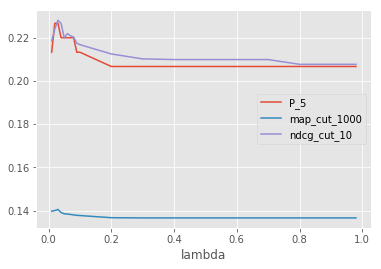

In [28]:
scores.drop('recall_1000',axis=1).plot()

### Dirichlet Prior

In [29]:
def dirichlet_prior(int_document_id, query_term_id, document_term_freq, mu=500):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    ## Amount of time a term appears in a document  
    df = document_term_freq
    
    ## tf, idf
    tf = np.log2(1 + (df/document_lengths[int_document_id]))
    
    ##p_w_C = P_mle_col[query_term_id])
    ## document length : document_lengths[int_document_id]

    return (tf+mu*P_mle_col[query_term_id])/(document_lengths[int_document_id]+mu)


In [30]:
#final run
start_time = time.time()
test_dict = run_retrieval('retrievals/dirichlet_prior',dirichlet_prior)
print ('elapsed time:',time.time()-start_time)

elapsed time: 0.00016951560974121094


In [31]:
for param_value in range(500,1501, 100):
    start_time = time.time()
    filename = 'retrievals/dirichlet_prior_mu='+str(param_value)
    
    run_retrieval(filename,dirichlet_prior, mu = param_value)
    
    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

finished retrievals/dirichlet_prior_mu=500 in 5.173683166503906e-05 sec
finished retrievals/dirichlet_prior_mu=600 in 0.00013566017150878906 sec
finished retrievals/dirichlet_prior_mu=700 in 2.8133392333984375e-05 sec
finished retrievals/dirichlet_prior_mu=800 in 2.0742416381835938e-05 sec
finished retrievals/dirichlet_prior_mu=900 in 1.7642974853515625e-05 sec
finished retrievals/dirichlet_prior_mu=1000 in 9.5367431640625e-06 sec
finished retrievals/dirichlet_prior_mu=1100 in 7.62939453125e-06 sec
finished retrievals/dirichlet_prior_mu=1200 in 8.58306884765625e-06 sec
finished retrievals/dirichlet_prior_mu=1300 in 6.198883056640625e-06 sec
finished retrievals/dirichlet_prior_mu=1400 in 5.7220458984375e-06 sec
finished retrievals/dirichlet_prior_mu=1500 in 5.7220458984375e-06 sec


In [32]:
filenames = glob.glob('./retrievals/dirichlet_prior_*')

In [33]:
scores = get_scores(filenames)
scores = pd.DataFrame.from_dict(scores,dtype=float)
scores.index.name='mu'

In [34]:
scores

,P_5,map_cut_1000,ndcg_cut_10,recall_1000
mu,,,,
500.0,0.1733,0.1029,0.1697,0.3946
600.0,0.1800,0.1066,0.1770,0.4041
700.0,0.1933,0.1122,0.1862,0.4081
800.0,0.1933,0.1145,0.1949,0.4111
900.0,0.1933,0.1167,0.1986,0.4142
1000.0,0.1933,0.1182,0.1998,0.4160
1100.0,0.1933,0.1201,0.2026,0.4182
1200.0,0.2000,0.1226,0.2076,0.4179
1300.0,0.2067,0.1236,0.2078,0.4177


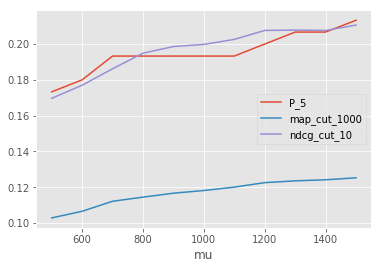

In [35]:
scores.drop('recall_1000',axis=1).plot()

In [36]:
# #trec_eval command for evalutaion of dirichlet_prior

# !trec_eval -m all_trec -q ./ap_88_89/qrel_validation dirichlet_prior.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

### Absolute discounting

In [37]:
def absolute_discounting(int_document_id, query_term_id, document_term_freq, delta=0.1):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    ## Amount of time a term appears in a document  
    df = document_term_freq
     
    
    ## tf, idf
    tf = np.log2(1 + (df/document_lengths[int_document_id]))
    
    ## p_w_C = P_mle_col[query_term_id])
    ## document length : document_lengths[int_document_id]
    ## document length u: collection_frequencies[query_term_id]
    
    doc_length = document_lengths[int_document_id]
    
    return ((np.max(tf-delta,0)/doc_length)+
            ((delta*collection_frequencies[query_term_id]*P_mle_col[query_term_id])/doc_length))


In [38]:
# #final run
# start_time = time.time()
# test_dict = run_retrieval('absolute_discounting',absolute_discounting)
# print ('elapsed time:',time.time()-start_time)

In [39]:
for param_value in np.arange(0.1,0.91, 0.1):
    start_time = time.time()
    filename = 'retrievals/absolute_discounting_delta='+str(param_value)
    
    run_retrieval(filename,absolute_discounting, delta = param_value)
    
    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

finished retrievals/absolute_discounting_delta=0.1 in 6.151199340820312e-05 sec
finished retrievals/absolute_discounting_delta=0.2 in 1.0013580322265625e-05 sec
finished retrievals/absolute_discounting_delta=0.3 in 0.0001246929168701172 sec
finished retrievals/absolute_discounting_delta=0.4 in 0.00012731552124023438 sec
finished retrievals/absolute_discounting_delta=0.5 in 2.2172927856445312e-05 sec
finished retrievals/absolute_discounting_delta=0.6 in 8.130073547363281e-05 sec
finished retrievals/absolute_discounting_delta=0.7 in 7.081031799316406e-05 sec
finished retrievals/absolute_discounting_delta=0.8 in 4.124641418457031e-05 sec
finished retrievals/absolute_discounting_delta=0.9 in 5.14984130859375e-05 sec


In [40]:
filenames = glob.glob('./retrievals/absolute_discounting_delta=*')

In [41]:
scores = get_scores(filenames)
scores = pd.DataFrame.from_dict(scores,dtype=float)
scores.index.name = 'delta'

In [42]:
scores

,P_5,map_cut_1000,ndcg_cut_10,recall_1000
delta,,,,
0.1,0.0800,0.0491,0.0860,0.1714
0.2,0.0400,0.0340,0.0408,0.1623
0.3,0.0267,0.0309,0.0230,0.1594
0.4,0.0267,0.0299,0.0197,0.1562
0.5,0.0267,0.0296,0.0191,0.1556
0.6,0.0267,0.0294,0.0188,0.1536
0.7,0.0267,0.0292,0.0188,0.1534
0.8,0.0267,0.0292,0.0188,0.1532
0.9,0.0267,0.0291,0.0187,0.1528


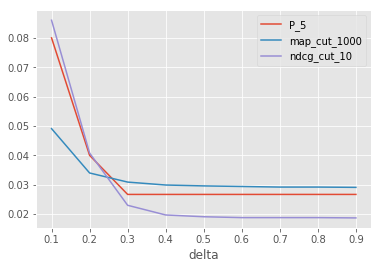

In [43]:
scores.drop('recall_1000',axis=1).plot()

** trec_eval command for evalutaion of dirichlet_prior **

!trec_eval -m all_trec -q ./ap_88_89/qrel_validation absolute_discounting.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

## Significance testing (on test set)

## TODO: change to test set

In [44]:
import re

In [45]:
ndcg_all={}

In [46]:
columns = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

ndcg = pd.DataFrame(columns=columns)

for param_value in columns:
    start_time = time.time()

    filename = 'retrievals/jelinek_mercer_lambda='+str(param_value)

    run_retrieval(filename,jelinek_mercer, lambd = param_value)

    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

    results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test { filename }.run | grep -E "^ndcg_cut_10\s"

    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        index = result[1]
        value = result[2]
        param_value = round(param_value,1)

        ndcg.set_value(index, param_value, value)
        
ndcg_all['jelinek_mercer'] = ndcg

finished retrievals/jelinek_mercer_lambda=0.1 in 0.00014281272888183594 sec
finished retrievals/jelinek_mercer_lambda=0.2 in 2.6226043701171875e-05 sec


/home/antonis/anaconda2/envs/ir/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


finished retrievals/jelinek_mercer_lambda=0.3 in 2.6702880859375e-05 sec
finished retrievals/jelinek_mercer_lambda=0.4 in 2.9325485229492188e-05 sec
finished retrievals/jelinek_mercer_lambda=0.5 in 2.7894973754882812e-05 sec
finished retrievals/jelinek_mercer_lambda=0.6 in 2.6941299438476562e-05 sec
finished retrievals/jelinek_mercer_lambda=0.7 in 2.5510787963867188e-05 sec
finished retrievals/jelinek_mercer_lambda=0.8 in 2.5272369384765625e-05 sec
finished retrievals/jelinek_mercer_lambda=0.9 in 2.8133392333984375e-05 sec


In [47]:
columns = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

ndcg = pd.DataFrame(columns=columns)

for param_value in columns:
    start_time = time.time()

    filename = 'retrievals/absolute_discounting_delta='+str(param_value)

    run_retrieval(filename,jelinek_mercer, lambd = param_value)

    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

    results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test { filename }.run | grep -E "^ndcg_cut_10\s"

    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        index = result[1]
        value = result[2]
        param_value = round(param_value,1)

        ndcg.set_value(index, param_value, value)

ndcg_all['absolute_discounting'] = ndcg

finished retrievals/absolute_discounting_delta=0.1 in 2.6702880859375e-05 sec
finished retrievals/absolute_discounting_delta=0.2 in 2.6464462280273438e-05 sec


/home/antonis/anaconda2/envs/ir/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


finished retrievals/absolute_discounting_delta=0.3 in 2.6941299438476562e-05 sec
finished retrievals/absolute_discounting_delta=0.4 in 3.361701965332031e-05 sec
finished retrievals/absolute_discounting_delta=0.5 in 2.8133392333984375e-05 sec
finished retrievals/absolute_discounting_delta=0.6 in 2.6464462280273438e-05 sec
finished retrievals/absolute_discounting_delta=0.7 in 2.9802322387695312e-05 sec
finished retrievals/absolute_discounting_delta=0.8 in 2.6941299438476562e-05 sec
finished retrievals/absolute_discounting_delta=0.9 in 2.7894973754882812e-05 sec


In [48]:
columns = np.arange(500,1501,100)

ndcg = pd.DataFrame(columns=columns)

for param_value in columns:
    start_time = time.time()

    filename = 'retrievals/dirichlet_prior_mu='+str(param_value)

    run_retrieval(filename,jelinek_mercer, lambd = param_value)

    print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))

    results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test { filename }.run | grep -E "^ndcg_cut_10\s"

    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        index = result[1]
        value = result[2]
        param_value = round(param_value,1)

        ndcg.set_value(index, param_value, value)

ndcg_all['dirichlet_prior'] = ndcg

finished retrievals/dirichlet_prior_mu=500 in 5.53131103515625e-05 sec
finished retrievals/dirichlet_prior_mu=600 in 3.9577484130859375e-05 sec


/home/antonis/anaconda2/envs/ir/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


finished retrievals/dirichlet_prior_mu=700 in 3.933906555175781e-05 sec
finished retrievals/dirichlet_prior_mu=800 in 4.076957702636719e-05 sec
finished retrievals/dirichlet_prior_mu=900 in 3.910064697265625e-05 sec
finished retrievals/dirichlet_prior_mu=1000 in 4.4345855712890625e-05 sec
finished retrievals/dirichlet_prior_mu=1100 in 3.933906555175781e-05 sec
finished retrievals/dirichlet_prior_mu=1200 in 3.9577484130859375e-05 sec
finished retrievals/dirichlet_prior_mu=1300 in 3.9577484130859375e-05 sec
finished retrievals/dirichlet_prior_mu=1400 in 4.363059997558594e-05 sec
finished retrievals/dirichlet_prior_mu=1500 in 5.14984130859375e-05 sec


In [49]:
# trec_eval command for evalutaion of tf-idf 

!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

ifidfdf = pd.DataFrame()

results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s"

for result in results:
    result = re.sub( '\s+', ' ', result ).strip().split()

    index = result[1]
    value = float(result[2])

    ifidfdf.set_value(index, 1, value)
    


P_5                   	all	0.1800
recall_1000           	all	0.4737
ndcg_cut_10           	all	0.1699
map_cut_1000          	all	0.1102


/home/antonis/anaconda2/envs/ir/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [50]:
# trec_eval command for evalutaion of bm25

!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/bm25.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

bm25df = pd.DataFrame()

results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test retrievals/bm25.run | grep -E "^ndcg_cut_10\s"

for result in results:
    result = re.sub( '\s+', ' ', result ).strip().split()

    index = result[1]
    value = float(result[2])

    bm25df.set_value(index, 1, value)


P_5                   	all	0.1133
recall_1000           	all	0.3840
ndcg_cut_10           	all	0.1069
map_cut_1000          	all	0.0769


/home/antonis/anaconda2/envs/ir/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [52]:
# TODO change to test values

best_scores = pd.DataFrame()
best_scores['absolute_discounting'] = ndcg_all['absolute_discounting'][0.1]
best_scores['jelinek_mercer'] = ndcg_all['jelinek_mercer'][0.1]
best_scores['dirichlet_prior'] = ndcg_all['dirichlet_prior'][1500]

best_scores['tf-idf'] = ifidfdf
best_scores['BM25'] = bm25df


best_scores = best_scores.applymap(lambda x: float(x))


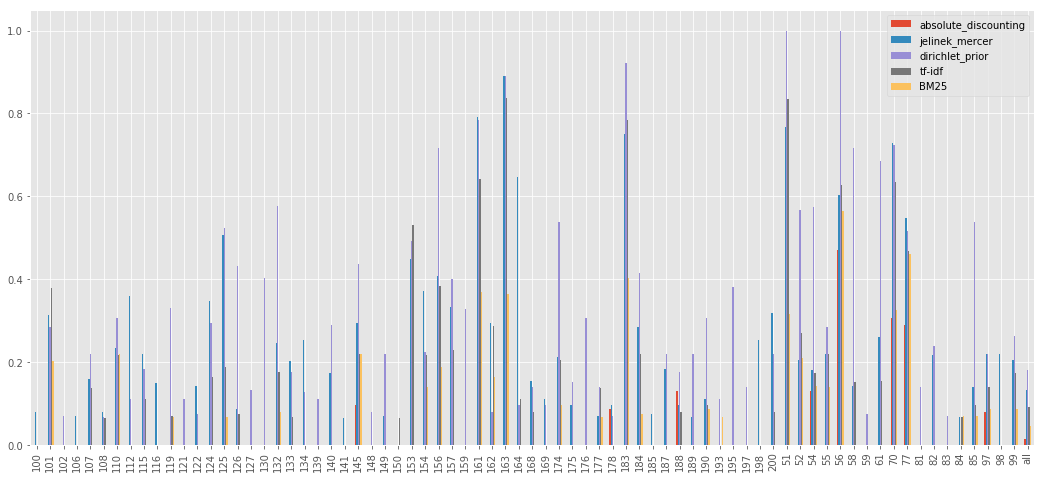

In [58]:
#plot non-zero queries only
best_scores[best_scores.sum(axis=1)>0].plot(kind='bar',figsize=(18,8))

In [ ]:
# pd.DataFrame(get_NDCG_score(f))

In [ ]:
# filenames = ['retrievals/absolute_discounting_delta=0.1.run',
#             'retrievals/absolute_discounting_delta=0.5.run',
#             'retrievals/absolute_discounting_delta=0.9.run',
#             ]

# score_df = pd.DataFrame()
# for filename in filenames:
#     score_df.append(pd.DataFrame( get_NDCG_score(filename = 'retrievals/absolute_discounting_delta=0.2.run')
#                  ,dtype=float, index=[filename.split('/')[-1]]))

In [ ]:
# 'retrievals/absolute_discounting_delta=0.1.run'
# !trec_eval -m all_trec ./ap_88_89/qrel_validation {filename1} | grep -E "^ndcg_cut_10\s"

In [ ]:
# def compare_scores(filename1, filename2, validation=True):
#     """
#     Function to get scores from trec_eval using a 
#     :param filenames: a list of *.run files (retrieval scores for queries)
#     :param validation: boolean. Perform evaluation on validation or test set (queries)
#     """
#     scores = {}
#     for filename in filenames:
#         param_value = float(filename.split("=")[-1].split('.run')[0])
#         if validation:
#             result1 = !trec_eval -m all_trec ./ap_88_89/qrel_validation {filename1} | grep -E "^ndcg_cut_10\s"
#         else:
#             result1 = !trec_eval -m all_trec ./ap_88_89/qrel_test {filename1} | grep -E "^ndcg_cut_10\s"

        
#         for row in result:
#             metric = row.split(' ')[0]
#             score = float(row.split('\t')[-1])
#             if metric not in scores.keys():
#                 scores[metric] = {}
#             scores[metric][param_value] = score
#     return scores

In [59]:
from scipy.stats import ttest_rel

In [63]:
def t_test(method1,method2,a=0.05):
    
    p_value = ttest_rel(method1, method2)[1]
    
    if p_value>a:
        return (p_value, 'not-rejected')
    else:
        return (p_value, 'rejected')
    
    
# t_test('jelinek_mercer','dirichlet_prior')    

In [60]:
from itertools import combinations

In [61]:
combs = list(combinations(best_scores.columns,2))

In [66]:
for pair in combs:
    print(pair[0],pair[1])
    print(t_test(best_scores[pair[0]],best_scores[pair[1]],a=0.05/len(best_scores)))
    print('\n')

absolute_discounting jelinek_mercer
(1.0479358060771439e-10, 'rejected')


absolute_discounting dirichlet_prior
(7.7104636555074727e-13, 'rejected')


absolute_discounting tf-idf
(8.5609582530146521e-07, 'rejected')


absolute_discounting BM25
(4.3934675970711097e-05, 'rejected')


jelinek_mercer dirichlet_prior
(0.000666099328372641, 'not-rejected')


jelinek_mercer tf-idf
(1.6566361017274397e-06, 'rejected')


jelinek_mercer BM25
(1.2248085475069692e-10, 'rejected')


dirichlet_prior tf-idf
(4.6901016485601283e-11, 'rejected')


dirichlet_prior BM25
(2.8518071922531019e-13, 'rejected')


tf-idf BM25
(1.99474150642697e-06, 'rejected')




### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

### Task 3:  Word embeddings for ranking [10 points] ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).

Try one of the following (increasingly complex) methods for building query and document representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248).
   
Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

### Task 4: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval, in particular pointwise learning to rank.

You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1 and Task 2 as features. Think about other features you can use (e.g. query/document length). 
One idea is to also explore external sources such as Wikipedia entities (?). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
